In [1]:
from CellClass import MCImage
from CellClass import imread
from CellClass import Preprocessing as pp
from CellClass.Segment import Segmentation
import numpy as np
import matplotlib.pyplot as plt

2022-06-03 14:48:25.362324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-03 14:48:25.362348: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
img = imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/processed/S4_200.tif")
print(img.shape)
MCIm = MCImage(img, scheme="BGR")
MCIm.normalize()

S = Segmentation()

(1496, 2048, 3)


2022-06-03 14:48:29.795516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-03 14:48:29.795623: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-03 14:48:29.795712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-

In [3]:
im, res, outline = S(MCIm.B, return_outline=True)
print(im.shape, res.shape, outline.shape)

/home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


(1496, 2048) (1496, 2048) (1496, 2048, 3)


In [6]:
from CellClass import process_masks as pm
import importlib
importlib.reload(pm)

patches = pm.get_cell_patches(MCIm, res, size=128)

100%|██████████| 594/594 [00:00<00:00, 1501.02it/s]


In [7]:
p = patches[0]

48 52


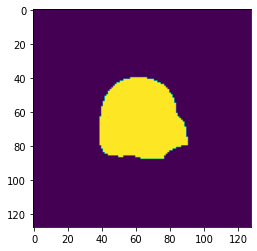

In [9]:
p.area
plt.imshow(p.mask)
print(p.y_size, p.x_size)

In [14]:
sizes = []
x, y = [], []
images = []
for p in patches:
    images.append(p.B)
    sizes.append(p.area)
    x.append(p.x_size)
    y.append(p.y_size)

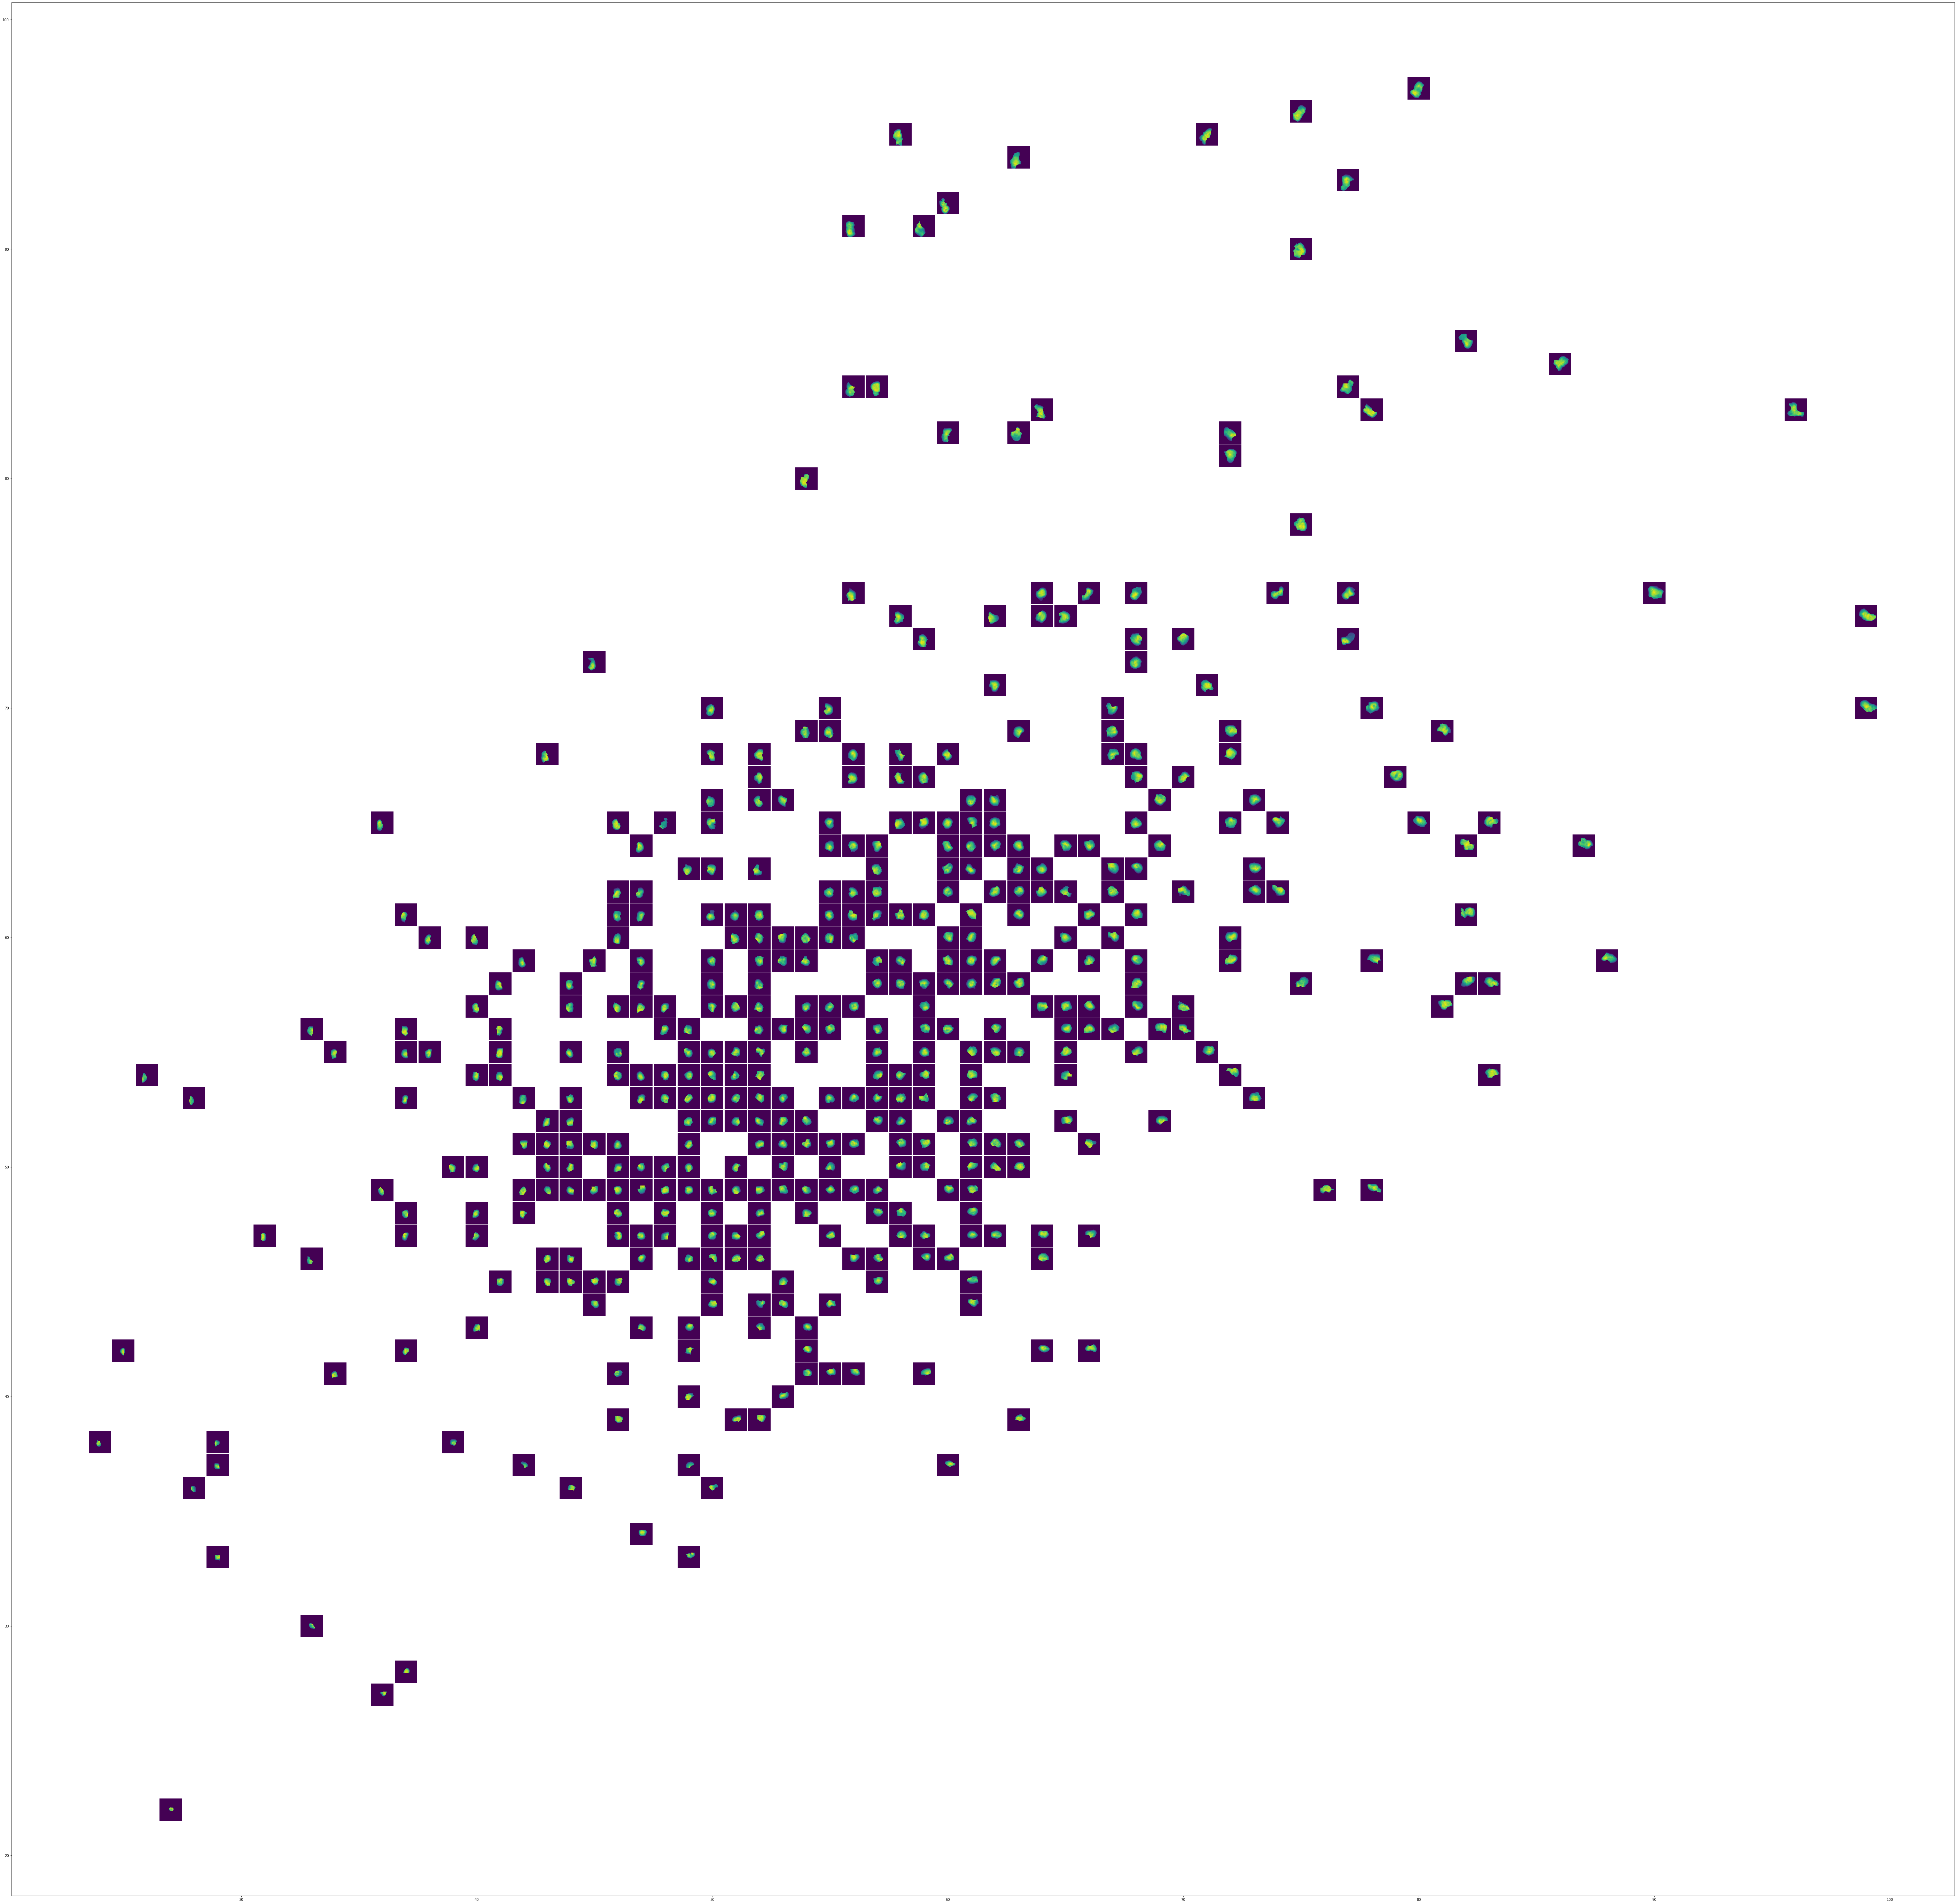

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2

%matplotlib inline

plt.rcParams['figure.figsize'] = 100,100

def main():
    fig, ax = plt.subplots()
    imscatter(x, y, images, zoom=.5, ax=ax)
    ax.scatter(x, y)
    plt.savefig('/home/simon_g/src/CellClass/scatter.eps', format='eps')
    #plt.show()

def imscatter(x, y, images,ax=None, zoom=10):
    if ax is None:
        ax = plt.gca()
    

    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, im in zip(x, y, images):
        #im = cv2.resize(im, (512, 512))
        im = OffsetImage(im, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists
main()